This notebook contains all experiments and functions to test out Wasserstein nearest neighbors for distributional matrix completion.

In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import pylab
import scipy
import pickle

import warnings
warnings.filterwarnings("ignore")

# NOTE: Whenever lambda functions are used, we create default variables when accessing
# outside variables. This is explained here: https://docs.python.org/3/faq/programming.html#id11

In [2]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 20
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['>', 'o',  's', 'D', '>', 's', 'o', 'D', '>', 's', 'o', 'D']


### Helper functions

In [3]:
def emp_wasserstein2(u: np.array, v: np.array):
    """
    Returns the squared 2-Wasserstein distance between two
    empirical distributions represented by arrays.
    Assumes the arrays of equal size and are sorted.
    """
    u_sorted = u
    v_sorted = v
    
    return np.sum(np.power(u_sorted - v_sorted,2)) / len(u)
    
def dissim(list1: list[np.array], list2: list[np.array]) -> float:
    """
    Returns a dissimilarity measure between two lists of
    data arrays. Only measures dissimilarity between
    lists that are observed.
    
    If no observations overlap then returns infinity.
    Else returns the average 2-wasserstein distance.
    """
    size = 0
    distance = 0
    for ind in range(len(list1)):
        if len(list1[ind]) == 1 and len(list2[ind]):
            distance += (list1[ind][0] - list2[ind][0]) ** 2
        else:
            # distance += adjusted_emp_wasserstein2(list1[ind], list2[ind]) # unbiased
            distance += emp_wasserstein2(list1[ind],list2[ind]) # biased
        size += 1
    if size == 0:
        return float('inf')
    return distance / size

def get_col(table, col):
    """
    Utility function to get the column of a table
    as a 1-dim list.
    """
    return [table[i][col] for i in range(len(table))]

def barycenter(lists: list[np.array]):
    """
    Returns the barycenter of a list of empirical distributions
    with the same number of samples.
    
    This is just the average of the order statistics of
    each empirical distribution.
    
    Assumes the arrays are of equal length and sorted.
    """
    sorted_data = lists
    
    sum_data = 0
    for l in sorted_data:
        sum_data += l
    
    return sum_data / len(lists)

The 2-Wasserstein metric has a closed-form solution in the 1-dimensional case:

$$W_2(\mu_1,\mu_2) = \left(\int_0^1 \left|F^{-1}_1(q) - F^{-1}_2(q)\right|^2\right)^{1/2}$$

where $F^{-1}_1$ and $F^{-1}_2$ are quantile functions for the distributions.

In [4]:
from scipy.integrate import quad
from scipy.stats import norm, uniform
from functools import partial
from numpy import quantile

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    y, _ = quad(lambda x : np.power((inv_cdf1(x) - inv_cdf2(x)), 2), 0, 1)
    return y

def wasserstein2_mc(ppf1, ppf2):
    N = 10000
    u = np.random.uniform(0,1,N)
    return np.sum(np.power(ppf1(u) - ppf2(u), 2)) / N

def empirical_quantile(data_arr):
    """
    Returns a function handle for the empirical quantile
    function given a 1-d dataset.
    """
    return lambda q, data_arr = data_arr : quantile(data_arr, q, method = 'inverted_cdf')

def uniform_ppf(left, right):
    return lambda q, left = left, scale = right - left : uniform.ppf(q, loc = left, scale = scale)

def normal_ppf(mean, std):
    return lambda q, mean = mean, std = std : norm.ppf(q, loc = mean, scale = std)

In [5]:
n = 1000

p1 = []
p2 = []
M = 10000

lefts = [0, -1, -2]
rights = [1, 1, 2]
m = len(lefts)
barycenters = []
for _ in range(M):
    data = []
    for l, r in zip(lefts, rights):
        d = np.sort(np.random.uniform(l,r,n))
        x = np.linspace(1 / (n+1), n / (n+1), n)
        data.append(d - uniform_ppf(l,r)(x))
    data = np.array(data)
    barycenter = np.sqrt(n) * np.mean(data, axis = 0)
    barycenters.append(barycenter)
barycenters = np.array(barycenters)
t_float = 0.3
s_float = 0.7

t = int(n * t_float)
s = int(n * s_float)
p1 = barycenters[:,t].flatten()
p2 = barycenters[:,s].flatten()
print(np.cov(p1,p2)[0,1])

0.20822360187693917


In [16]:
brownian_motion_cov = min(t_float, s_float) - (t_float * s_float)
# formula 1
sum_1 = sum((r - l) ** 2 for l, r in zip(lefts, rights)) # second moment
cov_1 = brownian_motion_cov * sum_1 / (m ** 2)

# formula 2
barycenter_left = np.mean(lefts)
barycenter_right = np.mean(rights)
barycenter_L = barycenter_right - barycenter_left
cov_2 = brownian_motion_cov * ((barycenter_L ** 2) + (sum((r - l - barycenter_L) ** 2 for l, r in zip(lefts, rights))) / 3) / m # first moment^2 + variance

print(cov_1, cov_2)

0.21 0.20999999999999994


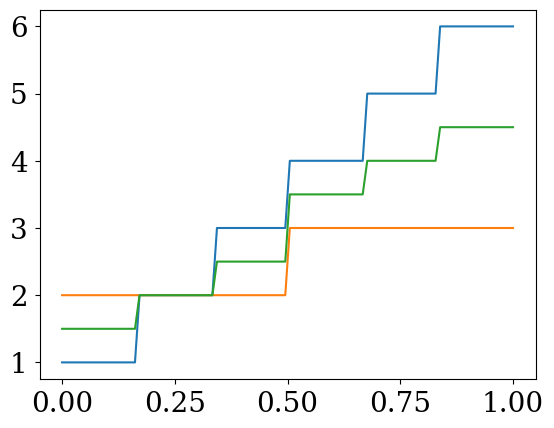

In [5]:
def f1(x):
    return empirical_quantile([1,2,3,4,5,6])(x)

def f2(x):
    return empirical_quantile([2,3])(x)

def f3(x):
    return (f1(x) + f2(x)) / 2

x = np.linspace(0,1,num=100)

plt.figure()
plt.plot(x,f1(x))
plt.plot(x,f2(x))
plt.plot(x,f3(x))
plt.show()

## Visualize Setup

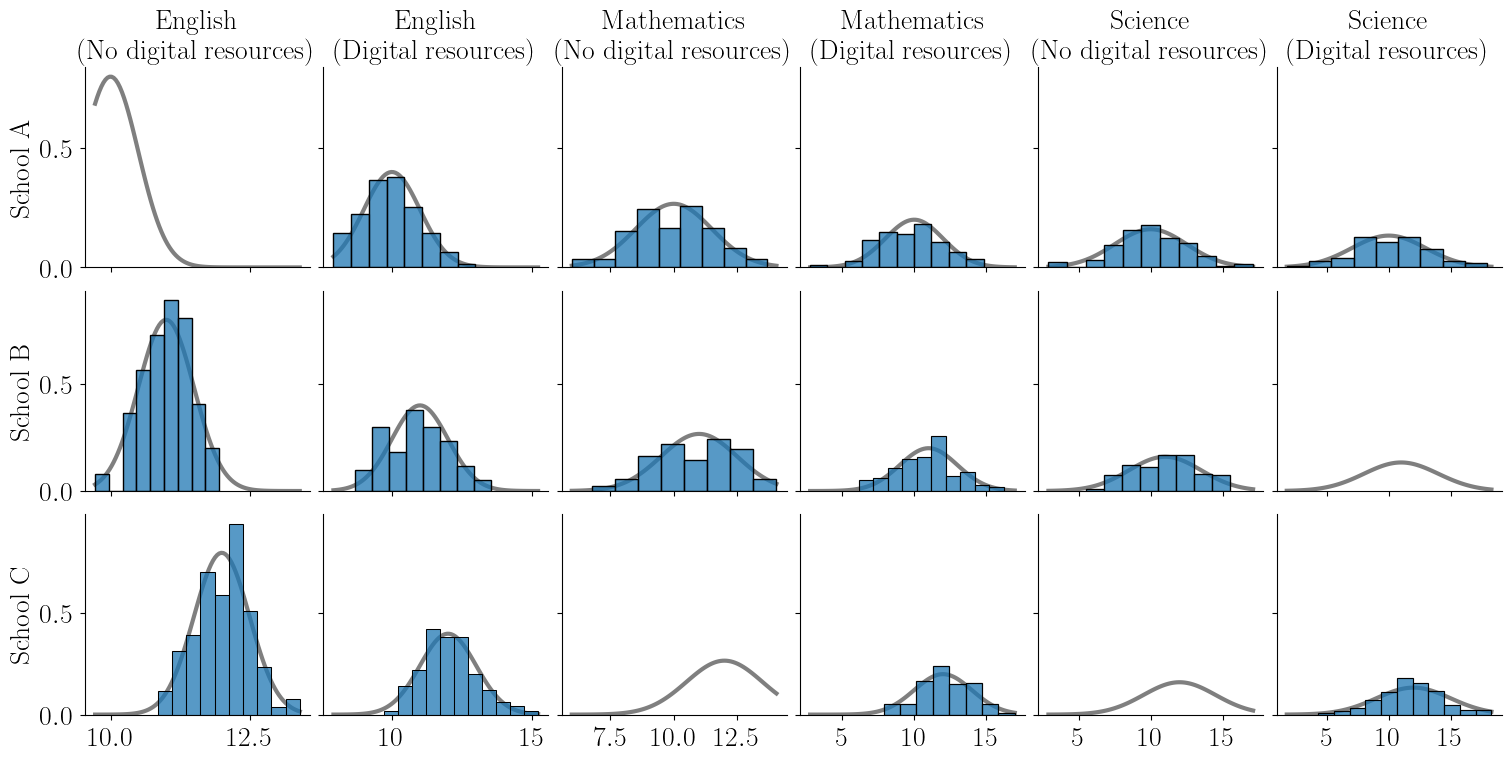

In [23]:
fig, axes = plt.subplots(3, 6, figsize=(15, 7.5), sharey='row', sharex='col', layout="compressed")
min_x = np.inf
max_x = -np.inf
skip = set([(0,0), (2,4), (1,5), (2,2)])
min_xs = {i: np.inf for i in range(6)}
max_xs = {i: -np.inf for i in range(6)}
for i in range(3):
    for j in range(6):
        if (i,j) in skip:
            continue
        data = np.random.normal(i+10,(j+1) * 0.5,100)
        sns.histplot(data, ax=axes[i,j], stat='density', zorder=1)
        min_xs[j] = min(min_xs[j], np.min(data))
        max_xs[j] = max(max_xs[j], np.max(data))

for i in range(3):
    for j in range(6):
        x = np.linspace(min_xs[j], max_xs[j], 100)
        pdf = scipy.stats.norm.pdf(x, i+10,(j+1) * 0.5)
        axes[i,j].plot(x, pdf,
                       linewidth=3,
                       alpha=0.5,
                       color='black',
                       zorder=0)
        # axes[i,j].grid(True, alpha=0.4, zorder=-1)
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)

axes[0,0].set_title("English\n(No digital resources)")
axes[0,1].set_title("English\n(Digital resources)")
axes[0,2].set_title("Mathematics\n(No digital resources)")
axes[0,3].set_title("Mathematics\n(Digital resources)")
axes[0,4].set_title("Science\n(No digital resources)")
axes[0,5].set_title("Science\n(Digital resources)")
axes[0,0].set_ylabel("School A")
axes[1,0].set_ylabel("School B")
axes[2,0].set_ylabel("School C")
plt.savefig("figures/setup.pdf")

## Experiments - Rates and Shape

### Helper Functions

In [5]:
def get_user_user_distances_fast(data_table, mask):
    """
    Vectorized version of user-user distances.
    Assumes data_table is a 3D numpy array.
    Assumes mask is a 2D numpy array.
    
    Assumes data is already sorted.
    """
    data_table = np.copy(data_table)
    mask = np.copy(mask)
    
    data_table[mask == 0,:] = np.inf # mask values as infinity for differences
    dists = np.power(data_table[:,None,:,:] - data_table, 2) # each pair of rows differenced
    row_dists = np.mean(dists, axis = 3) # average squared differences across samples
    np.nan_to_num(row_dists, copy = False, nan = 0, posinf=0) # convert nan and inf values to 0
    
    overlap = np.sum(mask[:,None,:] * mask, axis = 2) # get number of overlap elements between each pair of users
    row_dists = np.sum(row_dists, axis = 2) / overlap # average dists across columns
    
    np.fill_diagonal(row_dists, np.inf) # each user is not a nearest neighbor of itself

    return row_dists

def estimate_fast(data_table, mask, row, col, row_dists, eta):
    """
    Vectorized version of nearest neighbors.
    Assumes data_table is a 3D numpy array.
    Assumes mask is a 2D numpy array.
    
    Assumes data is already sorted.
    """
    NN = row_dists < eta # threshold to get nearest neighbors
    NN = NN[row] # get the nearest neighbors for the target user
    if np.sum(NN) > 0:
        return np.mean(data_table[NN, col, :], axis = 0) # barycenter of nearest neighbors
    else:
        data_masked = data_table * mask[:,:,None] # mask the data to exclude data not observed
        return np.mean(data_masked[:, col, :], axis = 0) # barycenter of entire observed column
def get_user_user_distances(data_table, mask, n_rows, n_cols):
    d = {}
    
    for i in range(n_rows):
        for u in range(i,n_rows):
            overlap = {j for j in range(n_cols) if mask[i,j] == 1 and mask[u,j] == 1}
            # if no overlap or looking at the same user
            if i == u or len(overlap) == 0:
                d[i,u] = np.inf
                d[u,i] = np.inf
                continue
            # if overlap, then calcualte dissimilarity
            d[i,u] = dissim([data_table[i,j] for j in range(n) if j in overlap],
                            [data_table[u,j] for j in range(n) if j in overlap])
            d[u,i] = d[i,u]
    return d

def estimate(data_table, mask, row, col, eta, n_rows, n_cols, distances):
    NN = {k for k in range(n_rows) if distances[row, k] <= eta}
    avg_inds = {}
    if len(NN) > 0:
        avg_inds = NN
    else:
        avg_inds = {k for k in range(n_rows) if mask[k,col] == 1}
    return barycenter([data_table[k,col] for k in avg_inds])

def get_user_user_distances_row(data_table, mask, row):
    rows, cols, samples = data_table.shape
    dists = np.zeros(rows)
    for i in range(rows):
        if i == row:
            dists[i] = np.inf
            continue
        dist = 0
        count = 0
        for j in range(cols):
            if mask[row,j] == 1 and mask[i,j] == 1:
                dist += emp_wasserstein2(data_table[row,j,:], data_table[i,j,:])
                count += 1
        dists[i] = dist / count
    return dists

def estimate_row(data_table, mask, col, row_dists, eta):
    NN = row_dists < eta # threshold to get nearest neighbors
    
    if np.sum(NN) > 0:
        masked = (NN * mask[:,col]) == 1 # need the ==1 to convert back to booleans
        return np.mean(data_table[masked,col,:], axis = 0)
    else:
        masked = (mask[:,col]) == 1
        return np.mean(data_table[masked, col,:], axis = 0)
from sklearn.model_selection import train_test_split
from copy import deepcopy
from hyperopt import hp, tpe, fmin

def evaluate_eta(data_table, mask, k, eta):
    """
    Run cross validation on the dataset with a given eta.
    """
    n_rows, n_cols,_ = data_table.shape
    observed_inds = np.array([(i,j) for i,j in product(range(n_rows), range(n_cols)) if mask[i,j] == 1])
    np.random.shuffle(observed_inds)
    chunks = np.array_split(observed_inds, k)
    error = 0
    
    for k_ind in range(k):
        test = chunks[k_ind] # left out
        train = np.concatenate([chunks[i] for i in range(k) if i != k_ind]) # everything else
        test_set = {tuple(t) for t in test}
        
        new_mask = np.copy(mask)
        for i,j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                new_mask[i,j] = 0
        dists = get_user_user_distances_fast(data_table, new_mask)
        
        for i, j in product(range(n_rows), range(n_cols)):
            if (i,j) in test_set:
                est = estimate_fast(data_table, new_mask, i,j, dists, eta)
                error += emp_wasserstein2(est, data_table[i,j])
                
    error /= len(observed_inds)
    return error

def evalute_eta_row(data_table, row, mask, eta):
    """
    Cross validate just on the row we are interested in estimating.
    """
    n_rows, n_cols,_ = data_table.shape
    observed_inds = np.array([j for j in range(n_cols) if mask[row,j] == 1])
    error = 0
    for k in observed_inds:
        new_mask = np.copy(mask)
        new_mask[row,k] = 0
        dists = get_user_user_distances_row(data_table, new_mask, row)
        est = estimate_row(data_table, new_mask, k, dists, eta)
        error += emp_wasserstein2(est, data_table[row,k])
    return error / len(observed_inds)

def search_eta(data_table, mask):
    """
    Search for an optimal eta using cross validation on
    the observed data.
    """
    def obj(eta):
    #     return evaluate_eta(data_table, mask, k, eta)
        return evalute_eta_row(data_table, 0, mask, eta)
    
    best_eta = fmin(fn=obj, verbose = False, space=hp.uniform('eta', 0.0001, 10.0), algo=tpe.suggest, max_evals=30)
    return best_eta['eta']
def simulate_nn_location_scale(M, N, n, n_runs, dist: str):
    np.random.seed(0)
    error_est = []
    error_observed = []
    num_neighbors = []

    for _ in tqdm(range(n_runs), desc=f'{M}, {N}, {n}'):
        # data_table = {}
        true_dists = {}

        # Table of n x m Gaussians with columns having same variance and rows having same means
        mean_rows = np.random.uniform(-5,5,M)
        std_cols = np.random.uniform(0.1,0.5,N)
        
        data_table = np.zeros((M, N, n))

        for i, j in product(range(M), range(N)):
            if dist == 'normal':
                data = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
                data_table[i,j,:] = data
                true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
            elif dist == 'uniform':
                data = np.sort(np.random.uniform(mean_rows[i], mean_rows[i] + std_cols[j], n))
                data_table[i,j,:] = data
                true_dists[i,j] = lambda q, mean = mean_rows[i], std = std_cols[j] : scipy.stats.uniform.ppf(q, mean, std)

        mask = np.ones((M,N)).astype(int)
        mask[0,0] = 0
        
        eta = search_eta(data_table, mask)

        d = get_user_user_distances_row(data_table, mask, 0)
        est_dist = estimate_row(data_table, mask, 0, d, eta)
        
        error_est.append(wasserstein2(empirical_quantile(est_dist), true_dists[0,0]))
        error_observed.append(wasserstein2(empirical_quantile(data_table[0,0]), true_dists[0,0]))

        num_neighbors.append(np.sum(d < eta)) # number of neighbors
    return error_est, error_observed, num_neighbors

### Experiment 1 - Shape of Distributions

In [93]:
M = 100
N = 20
n = 30

mean_rows = np.random.uniform(-5,5,M)
std_cols = np.random.uniform(1,5,N)
# std_cols = np.ones(N)
data_table = np.zeros((M, N, n))
data_table_dict = {}
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
    data_table[i,j,:] = data
    data_table_dict[i,j] = data
    true_dists[i,j] = normal_ppf(mean_rows[i], std_cols[j])
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

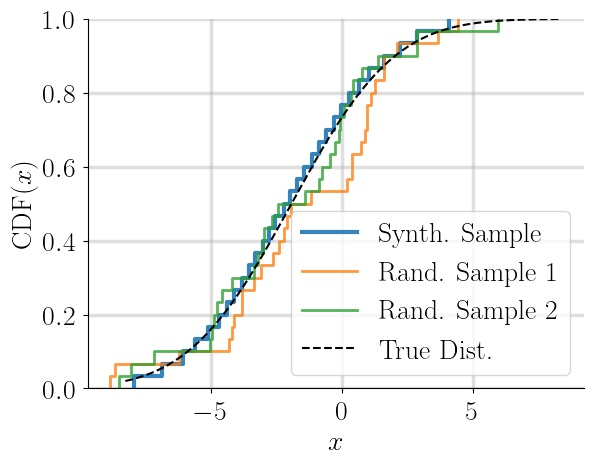

In [105]:
x_min = min(np.min(data_table[0,0]), np.min(est_dist))
x_max = max(np.max(data_table[0,0]), np.max(est_dist))
x = np.linspace(x_min, x_max, num = 1000)
y = scipy.stats.norm.cdf(x, mean_rows[0], std_cols[0])

mpl.rcParams['legend.fontsize'] = 20

# plt.hist(data_table[0,0], density = True, alpha = 0.8)
# plt.hist(est_dist, density = True, alpha = 0.8)
# plt.ecdf(data_table[0,0])
plt.ecdf(est_dist, linewidth=3, alpha=0.9)
for _ in range(2):
    plt.ecdf(np.random.normal(mean_rows[0], std_cols[0], n), linewidth=2, alpha=0.8)
# sample = np.random.normal(mean_rows[0], std_cols[0], n)
# plt.ecdf(sample)

# est_error = wasserstein2(empirical_quantile(est_dist), true_dists[0,0])
# true_error = wasserstein2(empirical_quantile(sample), true_dists[0,0])

plt.plot(x,y, '--', c='k',linewidth=1.5)
plt.legend(["Synth. Sample"] + [f"Rand. Sample {i + 1}" for i in range(2)] + ["True Dist."], loc='lower right')
# plt.legend(["Synthetic Sample", "Random Sample", "True Distribution"])
# plt.title(f"Gaussian Homoscedastic \n Random Sample Error = {true_error:.4f} \n Synthetic Sample Error = {est_error:.4f}")
# plt.title("Gaussian")
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
# plt.ylim([-0.1,1.1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.savefig(f"figures/denoising-norm-diff-var-cdf-more-random.pdf", bbox_inches="tight")

# print(est_error, true_error)

In [88]:
M = 100
N = 20
n = 30

mean_rows = np.random.uniform(-5,5,M)
std_cols = np.random.uniform(1,5,N)
# std_cols = np.ones(N)
data_table = np.zeros((M, N, n))
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.uniform(mean_rows[i], mean_rows[i] + std_cols[j], n))
    data_table[i,j,:] = data
    true_dists[i,j] = lambda q, mean = mean_rows[i], std = std_cols[j] : scipy.stats.uniform.ppf(q, mean, std)
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

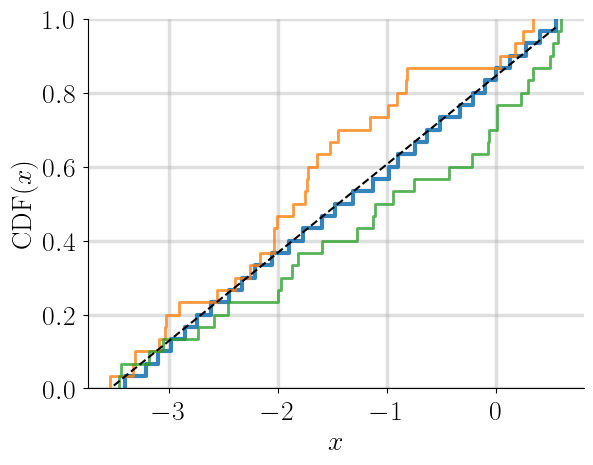

In [90]:
x_min = min(np.min(data_table[0,0]), np.min(est_dist))
x_max = max(np.max(data_table[0,0]), np.max(est_dist))
x = np.linspace(x_min, x_max, num = 1000)
y = scipy.stats.uniform.cdf(x, mean_rows[0], std_cols[0])

plt.ecdf(est_dist, linewidth=3, alpha=0.9)
for _ in range(2):
    plt.ecdf(np.random.uniform(mean_rows[0], mean_rows[0] + std_cols[0], n), linewidth=2, alpha=0.8)

# est_error = wasserstein2(empirical_quantile(est_dist), true_dists[0,0])
# true_error = wasserstein2(empirical_quantile(sample), true_dists[0,0])

plt.plot(x,y, '--', c='k',linewidth=1.5)
# plt.legend(["Synthetic Sample"] + [f"Random Sample {i + 1}" for i in range(2)] + ["True Distribution"])
# plt.legend(["Synthetic Sample", "Random Sample", "True Distribution"])
# plt.title(f"Gaussian Homoscedastic \n Random Sample Error = {true_error:.4f} \n Synthetic Sample Error = {est_error:.4f}")
# plt.title(f"CDF of DNN Synthetic vs. Random Samples\nUniform Heteroscedastic\n{n} Samples")
# plt.title("Uniform")
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
# plt.ylim([-0.1,1.1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.savefig(f"figures/denoising-unif-diff-var-cdf-more-random.pdf", bbox_inches="tight")

# print(est_error, true_error)

### Experiment 2 - Error Rates

In [37]:
errors_gaussian = {}

In [38]:
# cols = [5, 10, 25, 50, 75]
rows = [10, 50, 100, 1000]
# n_runs = 20
# samples = [2, 5, 10, 15, 25, 50, 100, 200, 1000]
n_runs = 10
cols = [30]
samples = [2, 10, 100, 500, 1000]

for M, N, n in product(rows, cols, samples):
    errors_gaussian[(M, N, n)] = simulate_nn_location_scale(M, N, n, n_runs, 'normal')

1000, 30, 1000: 100%|██████████| 10/10 [46:14<00:00, 277.46s/it]


In [6]:
import pickle

with open('error_files/errors_gauss.pickle', 'rb') as handle:
    errors_gaussian = pickle.load(handle)

In [39]:
with open('error_files/errors_gauss.pickle', 'wb') as handle:
    pickle.dump(errors_gaussian, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [360]:
with open('error_files/errors_row_3.pickle', 'wb') as handle:
    pickle.dump(errors_3, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
with open('error_files/errors_row_3.pickle', 'rb') as f:
    errors = pickle.load(f)

In [9]:
def fit_power(x,y):
    # y = a * (x ** b)
    # ln(y) = ln(a) + b * ln(x)
    ln_x = np.log(x).reshape(-1,1)
    ln_y = np.log(y).reshape(-1,1)

    X = np.concatenate([np.ones((len(x),1)), 
                        ln_x], 
                       axis=1)
    
    ab = (np.linalg.pinv(X) @ ln_y).flatten()
    
    return np.exp(ab[0]), ab[1]

def f(x,a,b):
    return a * (x ** b)

In [7]:
import pandas as pd

errors_dict = {
    'Rows': [],
    'Cols': [],
    'Samples': [],
    'Estimation Error': [],
    'Observed Error': [],
    'Neighbors': []
}

for k, v in errors_gaussian.items():
    for est, obs, nn in zip(*v):
        errors_dict['Rows'].append(k[0])
        errors_dict['Cols'].append(k[1])
        errors_dict['Samples'].append(k[2])
        errors_dict['Estimation Error'].append(est)
        errors_dict['Observed Error'].append(obs)
        errors_dict['Neighbors'].append(nn)

errors_df = pd.DataFrame.from_dict(errors_dict)

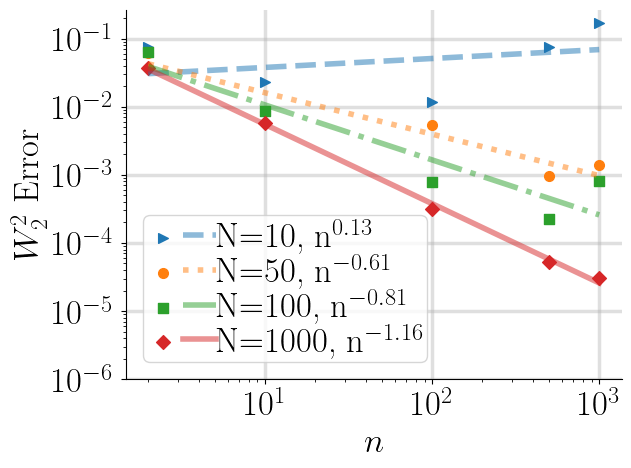

In [154]:
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple

label_size = 20 / 0.8
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

plt.figure()
# plt.tight_layout()
ax = plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

# ax.set_box_aspect(1)

ls = []
b = []
rows = [10, 50, 100, 1000]
for i, r in enumerate(rows):
    df = errors_df[errors_df['Rows'] == r]
    # filter out the rows with less than 2 neighbors
    df = df[df['Neighbors'] >= 2]
    mean = df.groupby('Samples').mean()

    l1 = ax.scatter(mean.index, mean['Estimation Error'], marker=mss[i])
    c,d = fit_power(np.array(mean.index), np.array(mean['Estimation Error']))
    l2, = ax.plot(mean.index,f(mean.index,c,d), lss[i], linewidth=4.0,alpha=0.5)
    b.append(d)

    ls.append((l1,l2))

ax.set_ylim(bottom=1e-6)
# ax.set_xlim(left=1e-1)
ax.set_xlabel("$n$")
ax.set_ylabel("$W_2^2$ Error")
# ax.set_title("$n$")
labels = [f"N={m}, " + r"n$^{%.2f}$"%(d) for m,d in zip(rows,b)]
ax.legend(handles = ls, labels = labels, loc='lower left',handletextpad=0.0,
          handler_map = {tuple: HandlerTuple(ndivide=None)}, borderpad=0.1, labelspacing=0)
plt.savefig("figures/error-samples-normal-N_2.pdf", bbox_inches="tight")

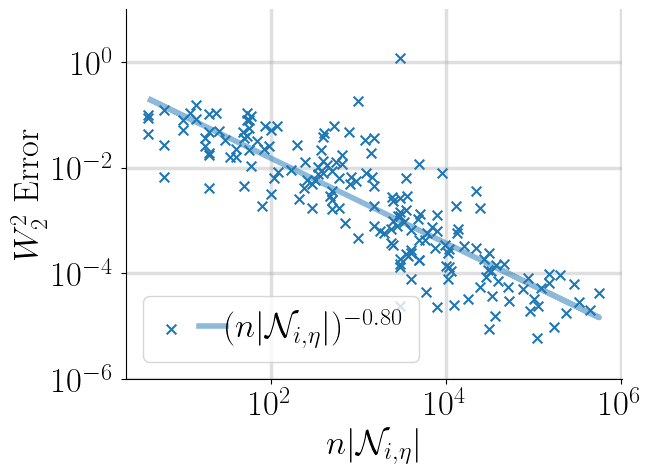

In [177]:
plt.figure()
ax = plt.gca()

ax.set_yscale('log')
ax.set_xscale('log')

label_size = 20 / 0.8
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

ls = []
b = []
rows = [10, 50, 100, 1000]
samples = [2, 10, 100, 500, 1000]

df = errors_df
df['n_N'] = df['Samples'] * df['Neighbors']
# filter out the rows with less than 1 neighbors
df = df[df['Neighbors'] >= 2]

l1 = ax.scatter(df['n_N'], df['Estimation Error'], marker='x')
c,d = fit_power(np.array(df['n_N']), np.array(df['Estimation Error']))
l2, = ax.plot(df['n_N'],f(df['n_N'],c,d), '-', linewidth=4.0,alpha=0.5)
b.append(d)

ls.append((l1,l2))

ax.set_ylim(bottom=1e-6, top=1e1)
ax.set_xlabel("$n|\mathcal{N}_{i,\eta}|$")
ax.set_ylabel("$W_2^2$ Error")

labels = [r"$(n|\mathcal{N}_{i,\eta}|)^{%.2f}$"%(d) for n,d in zip(samples,b)]
ax.legend(handles = ls, labels = labels, loc='lower left',handletextpad=0.0,
          handler_map = {tuple: HandlerTuple(ndivide=None)})

plt.savefig("figures/error-samples_x_neighbors-normal-N_2.pdf", bbox_inches="tight")

In [67]:
error = []
runs = 100
n = 500

for _ in tqdm(range(runs)):
    std = np.random.uniform(1,5)
    ppf = normal_ppf(0, std)
    data = np.random.normal(0,std,n)
    
    error.append(wasserstein2(empirical_quantile(data), ppf))

100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


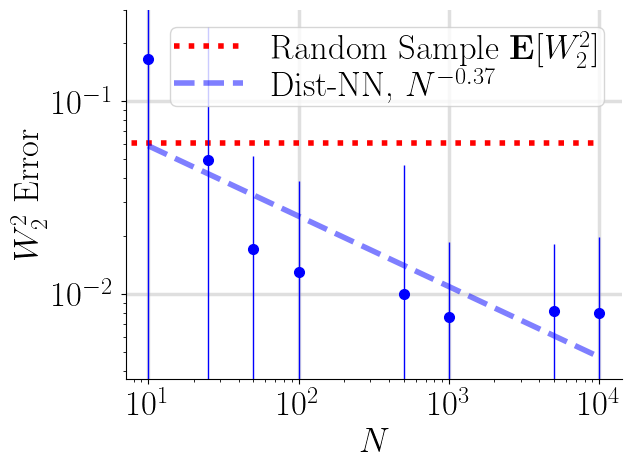

In [181]:
errors_avg = {k: np.mean(v[0]) for k, v in errors.items()}
errors_std = {k: 2 * np.std(v[0]) for k, v in errors.items()}

rows = [10, 25, 50, 100, 500, 1000, 5000, 10000]
s = 500
N = 10
y1 = np.array([errors_avg[m, N, s] for m in rows])
y_err = np.array([errors_std[m, N, s] for m in rows])
# y2 = np.array([errors_avg[m, 10, ss[1]] for m in x])
# y3 = np.array([errors_avg[m, 10, ss[2]] for m in x])

plt.figure()

label_size = 20 / 0.8
mpl.rcParams['lines.markersize'] = 7
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

plt.hlines(np.mean(error), 0, max(rows),colors='r',linestyles='dotted',linewidth=4.0)
plt.errorbar(rows, y1, yerr=y_err, fmt='o', color='b',linewidth=1.0)
# plt.scatter(rows,y1, marker='x', color='b')

def f(x,a,b):
    return a * (x ** b)

a, b = fit_power(rows, y1)
plt.plot(rows, f(rows,a,b), 'b--', alpha=0.5,linewidth=4.0)

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

plt.legend(["Random Sample $\mathbf{E}[W_2^2]$", r"Dist-NN, $N^{%.2f}$"%(b)], borderpad=0.1, labelspacing=0)
# plt.plot(x, y2, '.-', linewidth=2.0)
# plt.plot(x, y3, '.-', linewidth=2.0)
plt.xlabel("$N$")
plt.ylabel("$W_2^2$ Error")
# plt.title("$W_2^2$ Error vs. Number of Rows")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
ax.set_ylim(bottom=0, top = 0.3)
ax.set_xlim(left=0)
# plt.xticks([0] + x)
# plt.xticks(rows)

plt.savefig("figures/error_rows.pdf", bbox_inches="tight")
plt.show()

##E Experiment - Bootstrap confidence intervals

In [6]:
import scipy

def get_variance_exact(x: float, num_samples: int, neighbor_true_dists: list[scipy.stats.rv_continuous]) -> float:
    """
    Returns the confidence region for the true distribution
    given the true distributions of the neighbors.
    """
    if x < 0 or x > 1:
        raise ValueError("x must be in the range [0,1]")
    m = len(neighbor_true_dists)
    brownian_bridge_var = x - (x**2) # variance of the Brownian bridge
    neighbor_vars = np.sum(np.reciprocal([dist.pdf(dist.ppf(x)) ** 2 for dist in neighbor_true_dists])) # variance of the neighbors
    finite_sample_var = brownian_bridge_var * neighbor_vars / (num_samples * (m**2)) # variance of the barycenter estimate
    return finite_sample_var

def get_variance_bootstrap_neighbors(x: float, 
                                     num_samples: int, 
                                     neighbor_true_dists: list[scipy.stats.rv_continuous],
                                     num_resamples_neighbors = 10) -> float:
    """
    Returns the confidence region for the true distribution
    given the true distributions of the neighbors.
    """
    if x < 0 or x > 1:
        raise ValueError("x must be in the range [0,1]")
    variances = []
    m = len(neighbor_true_dists)
    neighbor_true_dists = np.array(neighbor_true_dists)
    
    for _ in range(num_resamples_neighbors):
        neighbors_inds = np.random.choice(m, m, replace=True)
        resampled_neighbors = neighbor_true_dists[neighbors_inds]
        var = get_variance_exact(x, num_samples, resampled_neighbors)
        variances.append(var)
    return np.mean(variances, axis=0)
    

def get_variance_bootstrap_samples(num_samples: int,
        neighbor_emp_dists: np.ndarray, 
        num_resamples_n = 10):
    m = len(neighbor_emp_dists)
    n = num_samples
    
    barycenters = []
    
    for _ in range(num_resamples_n):
        resampled_samples = np.zeros((m,n))
        for i in range(m):
            resampled_samples[i,:] = np.sort(np.random.choice(neighbor_emp_dists[i], n, replace=True))
        barycenter = np.mean(resampled_samples, axis = 0)
        barycenters.append(barycenter)
    barycenters = np.array(barycenters)
    
    return np.var(barycenters, axis=0, ddof=1)

def get_variance_bootstrap_everything(
        num_samples: int,
        neighbor_emp_dists: np.ndarray, 
        num_resamples_n = 10, 
        num_resamples_neighbors = 10):
    """
    Returns the confidence region for the true distribution
    using the bootstrap method.
    """
    m = len(neighbor_emp_dists)
    n = num_samples
    
    barycenters = []
    for _ in range(num_resamples_neighbors):
        neighbors_inds = np.random.choice(m, m, replace=True)
        resampled_neighbors = neighbor_emp_dists[neighbors_inds]
        for _ in range(num_resamples_n):
            resampled_samples = np.zeros((m,n))
            for i in range(m):
                resampled_samples[i,:] = np.sort(np.random.choice(resampled_neighbors[i], n, replace=True))
            barycenter = np.mean(resampled_samples, axis = 0)
            barycenters.append(barycenter)
    barycenters = np.array(barycenters)
    
    return np.var(barycenters, axis=0, ddof=1)

In [88]:
M = 100
N = 30
n = 30

mean_rows = np.random.uniform(-5,5,M)
std_cols = np.random.uniform(1,5,N)

data_table = np.zeros((M, N, n))
data_table_dict = {}
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.normal(mean_rows[i], std_cols[j], n))
    data_table[i,j,:] = data
    data_table_dict[i,j] = data
    true_dists[i,j] = scipy.stats.norm(mean_rows[i], std_cols[j])
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

Number of neighbors: 20


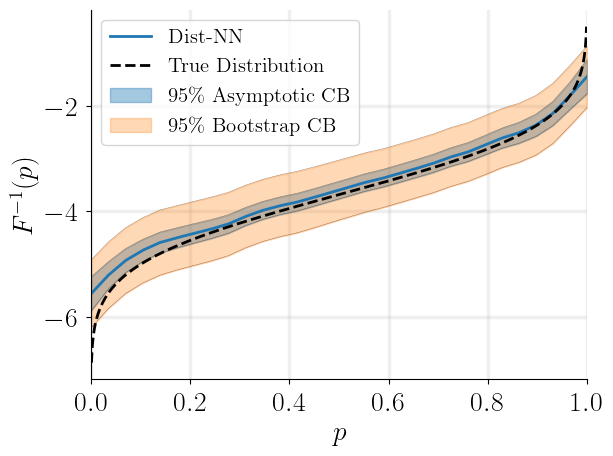

In [89]:
x = np.linspace(0, 1, num = 1000)
steps = [i / (n+1) for i in range(1,n+1)]

# set confidence level
alpha = 0.05
alpha = alpha / n # bonferonni correction
z_alpha = scipy.stats.norm.ppf(1 - (alpha / 2))

mpl.rcParams['legend.fontsize'] = 15 # font size for legend

plt.figure()
# plt.step(steps, est_dist, where='post', label='Dist-NN')
# plt.plot(steps, est_dist, label='Dist-NN')
plt.plot(x, np.quantile(est_dist, x), label='Dist-NN', linewidth=2)
plt.plot(x, true_dists[0,0].ppf(x), label='True Distribution', linewidth=2, linestyle='--', color='k')
plt.xlabel('$p$')
plt.xlim([0,1])
plt.ylabel('$F^{-1}(p)$')

neighbor_dists = [true_dists[i,0] for i in range(M) if d[i] < eta] # get the neighbors
print(f'Number of neighbors: {len(neighbor_dists)}')


std_true = np.array([np.sqrt(get_variance_bootstrap_neighbors(s, n, neighbor_dists)) for s in steps]) # get the true asymptotic standard deviation
top = est_dist + (z_alpha * std_true) # 95% confidence region
bottom = est_dist - (z_alpha * std_true) # 95% confidence region
plt.plot(x, np.quantile(bottom, x), color='black', linewidth=0.25, alpha=0.5)
plt.plot(x, np.quantile(top, x), color='black', linewidth=0.25, alpha=0.5)
plt.fill_between(x, np.quantile(bottom, x), np.quantile(top, x), 
                 alpha=0.4, 
                 color='tab:blue',
                 interpolate=False, 
                 label='95\% Asymptotic CB')


neighbor_dists = [true_dists[i,0] for i in range(M) if d[i] < eta] # get the neighbors
std_bootstrap = np.sqrt(get_variance_bootstrap_everything(n,data_table[d < eta, 0, :], 
                                                          num_resamples_n=50,
                                                          num_resamples_neighbors=50)) # get the true asymptotic standard deviation
top = est_dist + (z_alpha * std_bootstrap) # 95% confidence region
bottom = est_dist - (z_alpha * std_bootstrap) # 95% confidence region

plt.plot(x, np.quantile(bottom, x), color='black', linewidth=0.25, alpha=0.5)
plt.plot(x, np.quantile(top, x), color='black', linewidth=0.25, alpha=0.5)
plt.fill_between(x, np.quantile(bottom, x), np.quantile(top, x), 
                 alpha=0.3, 
                 color='tab:orange',
                 interpolate=False, 
                 label='95\% Bootstrap CB')

plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2)

# plt.ylim([-10,10])
plt.savefig("figures/norm-confidence-region.pdf", bbox_inches="tight")
plt.show()

#### Uniform

In [79]:
M = 100
N = 30
n = 30

mean_rows = np.random.uniform(-5,5,M)
std_cols = np.random.uniform(1,5,N)

data_table = np.zeros((M, N, n))
data_table_dict = {}
true_dists = {}
for i, j in product(range(M), range(N)):
    data = np.sort(np.random.uniform(mean_rows[i], mean_rows[i] + std_cols[j], n))
    data_table[i,j,:] = data
    data_table_dict[i,j] = data
    true_dists[i,j] = scipy.stats.uniform(mean_rows[i], std_cols[j])
mask = np.ones((M,N)).astype(int)
mask[0,0] = 0

eta = search_eta(data_table, mask)
d = get_user_user_distances_row(data_table, mask, 0)
est_dist = estimate_row(data_table, mask, 0, d, eta)

Number of neighbors: 20


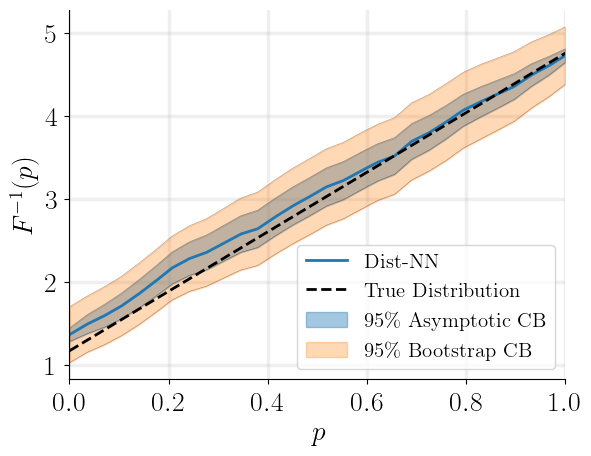

In [81]:
x = np.linspace(0, 1, num = 1000)
steps = [i / (n+1) for i in range(1,n+1)]

# set confidence level
alpha = 0.05
alpha = alpha / n # bonferonni correction
z_alpha = scipy.stats.norm.ppf(1 - (alpha / 2))

mpl.rcParams['legend.fontsize'] = 15 # font size for legend

plt.figure()
# plt.step(steps, est_dist, where='post', label='Dist-NN')
# plt.plot(steps, est_dist, label='Dist-NN')
plt.plot(x, np.quantile(est_dist, x), label='Dist-NN', linewidth=2)
plt.plot(x,true_dists[0,0].ppf(x), label='True Distribution', linewidth=2, linestyle='--', color='k')
plt.xlabel('$p$')
plt.xlim([0,1])
plt.ylabel('$F^{-1}(p)$')

neighbor_dists = [true_dists[i,0] for i in range(M) if d[i] < eta] # get the neighbors
print(f'Number of neighbors: {len(neighbor_dists)}')

std = np.array([np.sqrt(get_variance_bootstrap_neighbors(s, n, neighbor_dists)) for s in steps]) # get the true asymptotic standard deviation
top = est_dist + (z_alpha * std) # 95% confidence region
bottom = est_dist - (z_alpha * std) # 95% confidence region
plt.plot(x, np.quantile(bottom, x), color='black', linewidth=0.25, alpha=0.5)
plt.plot(x, np.quantile(top, x), color='black', linewidth=0.25, alpha=0.5)
plt.fill_between(x, np.quantile(bottom, x), np.quantile(top, x), 
                 alpha=0.4, 
                 color='tab:blue',
                 interpolate=False, 
                 label='95\% Asymptotic CB')


neighbor_dists = [true_dists[i,0] for i in range(M) if d[i] < eta] # get the neighbors
std = np.sqrt(get_variance_bootstrap_everything(n,data_table[d < eta, 0, :],
                                     num_resamples_n=50,
                                     num_resamples_neighbors=50)) # get the true asymptotic standard deviation
top = est_dist + (z_alpha * std) # 95% confidence region
bottom = est_dist - (z_alpha * std) # 95% confidence region

plt.plot(x, np.quantile(bottom, x), color='black', linewidth=0.25, alpha=0.5)
plt.plot(x, np.quantile(top, x), color='black', linewidth=0.25, alpha=0.5)
plt.fill_between(x, np.quantile(bottom, x), np.quantile(top, x), 
                 alpha=0.3, 
                 color='tab:orange',
                 interpolate=False, 
                 label='95\% Bootstrap CB')

plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.2)

# plt.ylim([2,6])

plt.savefig("figures/unif-confidence-region.pdf", bbox_inches="tight")
plt.show()

### Experiment 3 - Variance and Value-at-Risk

In [206]:
M = 100
N = 20
n = 10

alpha = 0.05
n_trials = 50

np.random.seed(0)

# Dist-NN Errors
std_dnn_errors = []
var_dnn_errors = []
mean_dnn_errors = []
median_dnn_errors = []

# Scalar NN Errors
std_snn_errors = []
var_snn_errors = []
mean_snn_errors = []
median_snn_errors = []

# Random sample errors
std_rand_errors = []
var_rand_errors = []
mean_rand_errors = []
median_rand_errors = []

for _ in tqdm(range(n_trials)):
    true_dists = {}

    # Table of n x m Gaussians with columns having same variance and rows having same means
    mean_rows = np.random.uniform(-5,5,M)
    std_cols = np.random.uniform(1,5,N)
    
    data_table = np.zeros((M, N, n))
    data_table_std = np.zeros((M,N,1))
    data_table_var = np.zeros((M,N,1))
    data_table_mean = np.zeros((M,N,1))
    data_table_median = np.zeros((M,N,1))

    for i, j in product(range(M), range(N)):
        data_unif = np.sort(np.random.uniform(0,1,n))
        ppf = normal_ppf(mean_rows[i], std_cols[j])
        data = ppf(data_unif)
        
        data_table[i,j,:] = data
        true_dists[i,j] = ppf
        
        data_table_std[i,j,:] = np.std(data_table[i,j,:], keepdims = True)
        data_table_var[i,j,:] = empirical_quantile(-1 * data)(1 - alpha)
        data_table_mean[i,j,:] = np.mean(data_table[i,j,:], keepdims = True)
        data_table_median[i,j,:] = np.median(data_table[i,j,:], keepdims = True)

    mask = np.ones((M,N)).astype(int)
    mask[0,0] = 0
    
    data_tables = [data_table, data_table_std, data_table_var, data_table_mean, data_table_median]
    ests = []
    
    for table in data_tables:
        eta = search_eta(table, mask)
        d = get_user_user_distances_row(table, mask, 0)
        est = estimate_row(table, mask, 0, d, eta)
        ests.append(est)

    var_nn = empirical_quantile(-1 * ests[0])(1 - alpha)
    var_random = empirical_quantile(-1 * data_table[0,0])(1 - alpha)
    var_true = normal_ppf(-1 * mean_rows[0], std_cols[0])(1-alpha)
    
    # Dist-NN
    std_dnn_errors.append((np.std(ests[0]) - std_cols[0]) ** 2)
    var_dnn_errors.append((var_nn - var_true) ** 2)
    mean_dnn_errors.append((np.mean(ests[0]) - mean_rows[0]) ** 2)
    median_dnn_errors.append((np.median(ests[0]) - mean_rows[0]) ** 2)
    
    # Scalar-NN
    std_snn_errors.append((ests[1][0] - std_cols[0]) ** 2)
    var_snn_errors.append((ests[2][0] - var_true) ** 2)
    mean_snn_errors.append((ests[3][0] - mean_rows[0]) ** 2)
    median_snn_errors.append((ests[4][0] - mean_rows[0]) ** 2)
    
    # Random Sample
    std_rand_errors.append((np.std(data_table[0,0]) - std_cols[0]) ** 2)
    var_rand_errors.append((var_random - var_true) ** 2)
    mean_rand_errors.append((np.mean(data_table[0,0]) - mean_rows[0]) ** 2)
    median_rand_errors.append((np.median(data_table[0,0]) - mean_rows[0]) ** 2)

100%|██████████| 50/50 [12:06<00:00, 14.53s/it]


In [216]:
dist_errors_dict = {
    'std_dnn': std_dnn_errors,
    'var_dnn': var_dnn_errors,
    'mean_dnn': mean_dnn_errors,
    'median_dnn': median_dnn_errors,
    'std_snn': std_snn_errors,
    'var_snn': var_snn_errors,
    'mean_snn': mean_snn_errors,
    'median_snn': median_snn_errors,
    'std_rand': std_rand_errors,
    'var_rand': var_rand_errors,
    'mean_rand': mean_rand_errors,
    'median_rand': median_rand_errors
}

In [217]:
with open('error_files/dist_errors.pickle', 'wb') as handle:
    pickle.dump(dist_errors_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
dist_errors_dict = {}
with open('error_files/dist_errors.pickle', 'rb') as f:
    dist_errors_dict = pickle.load(f)

In [10]:
label_size = 30
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

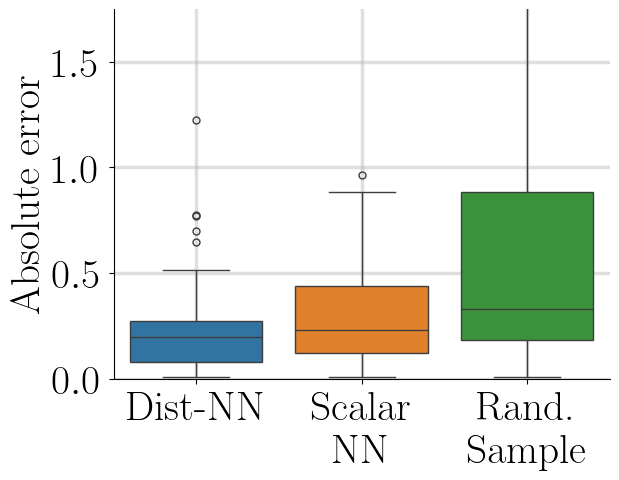

In [13]:
mean_errors_total = np.array([
    dist_errors_dict['mean_dnn'],
    dist_errors_dict['mean_snn'],
    dist_errors_dict['mean_rand']
]).T
mean_errors_total = np.sqrt(mean_errors_total)
labels = ["Dist-NN", "Scalar\nNN", "Rand.\nSample"]
ax = sns.boxplot(mean_errors_total)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)

plt.ylim([0,1.75])
ax.set_xticklabels(labels)
plt.ylabel("Absolute error")
plt.savefig("figures/mean.pdf", bbox_inches="tight")
plt.show()

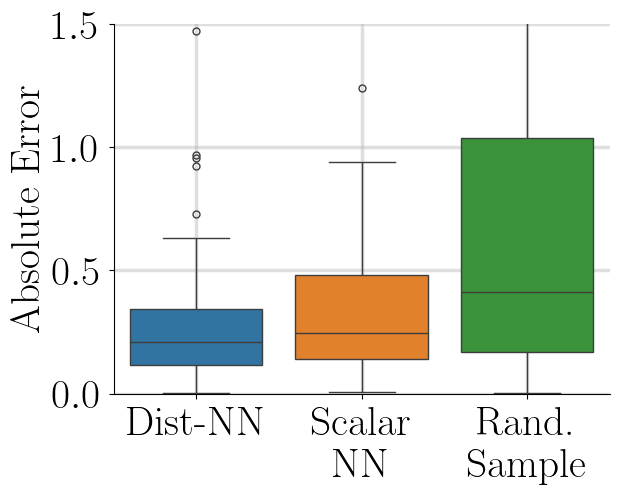

In [14]:
median_errors_total = np.array([
    dist_errors_dict['median_dnn'],
    dist_errors_dict['median_snn'],
    dist_errors_dict['median_rand']
]).T
median_errors_total = np.sqrt(median_errors_total)
labels = ["Dist-NN", "Scalar\nNN", "Rand.\nSample"]
ax = sns.boxplot(median_errors_total)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.ylim([0,1.5])
ax.set_xticklabels(labels)
plt.ylabel("Absolute Error")
plt.savefig("figures/median.pdf", bbox_inches="tight")
plt.show()

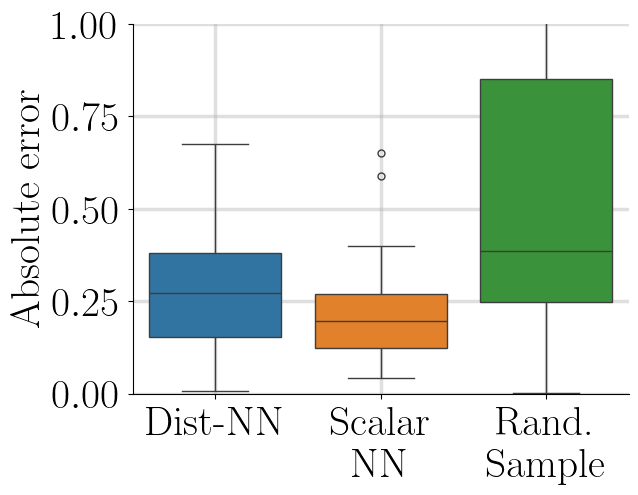

In [15]:
std_errors_total = np.array([
    dist_errors_dict['std_dnn'],
    dist_errors_dict['std_snn'],
    dist_errors_dict['std_rand']
]).T
std_errors_total = np.sqrt(std_errors_total)
labels = ["Dist-NN", "Scalar\nNN", "Rand.\nSample"]
ax = sns.boxplot(std_errors_total)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.ylim([0,1.0])
ax.set_xticklabels(labels)
plt.ylabel("Absolute error")
plt.savefig("figures/std.pdf", bbox_inches="tight")
plt.show()

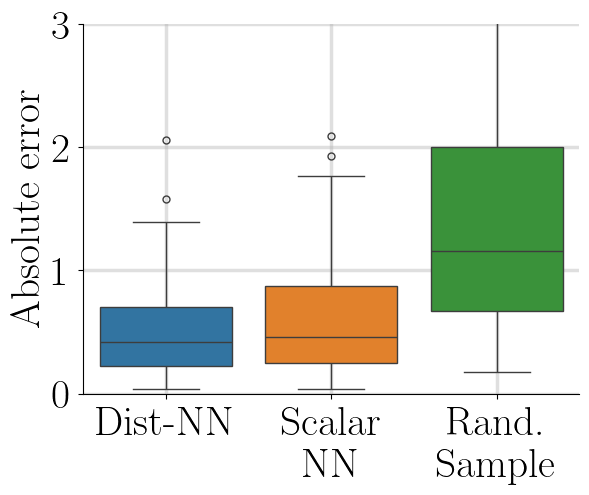

In [16]:
var_errors_total = np.array([
    dist_errors_dict['var_dnn'],
    dist_errors_dict['var_snn'],
    dist_errors_dict['var_rand']
]).T
var_errors_total = np.sqrt(var_errors_total)
labels = ["Dist-NN", "Scalar\nNN", "Rand.\nSample"]
ax = sns.boxplot(var_errors_total)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
plt.ylim([0,3.0])
ax.set_xticklabels(labels)
plt.ylabel("Absolute error")
plt.savefig("figures/var.pdf", bbox_inches="tight")
plt.show()

## Experiment 4 - Uniform Data

In [11]:
def expected_unif_distance(a,b,c,d,n):
    diff1 = b - a
    diff2 = d - c

    return (((diff1 - diff2)**2 )/ 3) + ((a - c)**2) + ((a-c)*(diff1 - diff2)) + ((diff1 * diff2) / (3*(n+1)))

difference = []

a = -2
b = 2
c = 0
d = 1
n = 1000

for _ in tqdm(range(100000)):
    data1 = np.sort(np.random.uniform(a,b,n))
    data2 = np.sort(np.random.uniform(c,d,n))

    difference.append(np.mean(np.power(data1 - data2, 2)))

expected_unif_distance(a,b,c,d,n), np.mean(difference)

100%|██████████| 100000/100000 [00:09<00:00, 10532.46it/s]


(1.0013320013320013, 1.0013753873261013)